In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
transform=transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
trainset=torchvision.datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
trainloader=torch.utils.data.DataLoader(trainset,batch_size=4,shuffle=True,num_workers=2)
testset=torchvision.datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
testloader=torch.utils.data.DataLoader(testset,batch_size=4,shuffle=False,num_workers=2)
classes=('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


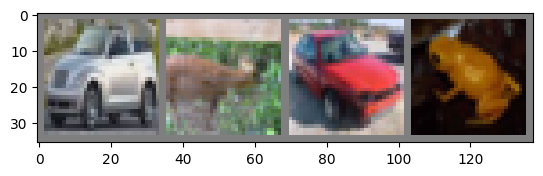

<generator object <genexpr> at 0x7908a68d8040>


In [ ]:
def imshow(img):
  img=img/2+0.5
  npimg=img.numpy()
  plt.imshow(np.transpose(npimg,(1,2,0)))
  plt.show()
#随机获取训练集图片
dataiter=iter(trainloader)
images,labels=next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(" ".join("%5s") % classes[labels[j]] for j in range(4))

In [ ]:
#构建卷积神经网络
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.conv1=nn.Conv2d(3,6,5)
    self.pool=nn.MaxPool2d(2,2)
    self.conv2=nn.Conv2d(6,16,5)
    self.fc1=nn.Linear(16*5*5,120)
    self.fc2=nn.Linear(120,84)
    self.fc3=nn.Linear(84,10)
  def forward(self,x):
    x=self.pool(F.relu(self.conv1(x)))
    x=self.pool(F.relu(self.conv2(x)))
    x=x.view(-1,16*5*5)
    x=F.relu(self.fc1(x))
    x=F.relu(self.fc2(x))
    x=self.fc3(x)
    return x
net=Net()

In [ ]:
#定义损失函数和优化器
import torch.optim as optim
loss=nn.CrossEntropyLoss()
optimizer=optim.SGD(net.parameters(),lr=0.001,momentum=0.9)

In [ ]:
#训练网络
import time
start=time.time()
for epoch in range(2):
  running_loss=0.0
  for i,data in enumerate(trainloader,0):
    #获取输入数据
    inputs,labels=data
    #清空梯度缓存
    optimizer.zero_grad()
    outputs=net(inputs)
    l=loss(outputs,labels)
    l.backward()
    optimizer.step()
    #打印统计信息
    running_loss+=l.item()
    if i%2000==1999:
      print("[%d,%5d] loss:%.3f" % (epoch+1,i+1,running_loss/2000))
      running_loss=0.0
print('Finished Training! Total cost time: ',time.time()-start)

[1, 2000] loss:2.183
[1, 4000] loss:1.889
[1, 6000] loss:1.684
[1, 8000] loss:1.582
[1,10000] loss:1.527
[1,12000] loss:1.461
[2, 2000] loss:1.392
[2, 4000] loss:1.383
[2, 6000] loss:1.359
[2, 8000] loss:1.350
[2,10000] loss:1.312
[2,12000] loss:1.304
Finished Training! Total cost time:  140.0530822277069


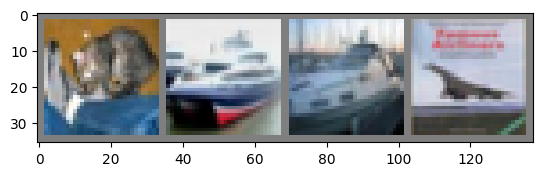

GroundTruth:    cat  ship  ship plane


In [ ]:
#测试模型性能
dataiter=iter(testloader)
images,labels=next(dataiter)
#打印图片
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
preds=net(images)
_,predicted=torch.max(preds,1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat   car   car  ship


In [ ]:
correct=0
total=0
with torch.no_grad():
  for data in testloader:
    images,labels=data
    preds=net(images)
    _,predicted=torch.max(preds.data,1)#返回每行的最大值及其对应标签，1表示按行求最大值
    total+=labels.shape[0]
    correct+=(predicted==labels).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

In [ ]:
labels.size()

torch.Size([4])